# Toy model F=1/2 and F=3/2

In [8]:
# Import the packages required for the notebook
using
    Revise,
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

┌ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
└ @ Base loading.jl:1662


## Create the Ground State

In [9]:
# Ground state
QN_bounds_g_12 = (F=1/2,E=0)
QN_bounds_g_32 = (F=3/2, E=80)
basis_g_12 = enumerate_states(AngularMomentumState, QN_bounds_g_12)
basis_g_32 = enumerate_states(AngularMomentumState, QN_bounds_g_32)
basis_g = [basis_g_12; basis_g_32]

# Excited state
QN_bounds_e_12 = (F=1/2, E=0)
basis_e = enumerate_states(AngularMomentumState, QN_bounds_e_12)
;

2-element Vector{AngularMomentumState}:
 AngularMomentumState(0.0, 1/2, -1/2, (M = -0.5:1.0:0.5,))
 AngularMomentumState(0.0, 1/2, 1/2, (M = -0.5:1.0:0.5,))

In [10]:
# Add Zeeman term
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = δ(state,state′) * (state.F == 1/2 ? state.M*1 : state.M*2)

H_operator = :(
    prefac1 * H + 
    prefac2 * H
)

parameters = @params begin
    prefac1 = 0.5 # need to have two copies of this just to make sure that Julia doesn't attempt to 'reduce over an empty list'
    prefac2 = 0.5 # make this equal to prefac1 for the 'reduce over empty list' reason...
end

# Ground state
ham_g = Hamiltonian(basis=basis_g, operator=H_operator, parameters=parameters)

ham_g = add_to_H(ham_g, :Bz, gS * _μB * Zeeman_z)
ham_g.parameters.Bz = 0.0
evaluate!(ham_g)
QuantumStates.solve!(ham_g)


# Excited state
ham_e = Hamiltonian(basis=basis_e, operator=H_operator, parameters=parameters)

ham_e = add_to_H(ham_e, :Bz, 0.01 * gS * _μB * Zeeman_z)
ham_e.parameters.Bz = 0.0
evaluate!(ham_e)
QuantumStates.solve!(ham_e)
;

## Zeeman plot

Let's make a Zeeman plot for the $X$ state. This code snippet can be adapted to scanning any other paramter of the Hamiltonian.

In [11]:
function H_func!(H, scan_values)
    H.parameters.Bz = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [12]:
Bs = (0:0.1:20)
scan_params = (
    Bz = Bs,
    );
iterator = Iterators.product
scan_values, tracked_idxs = scan_parameters(ham_g, scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


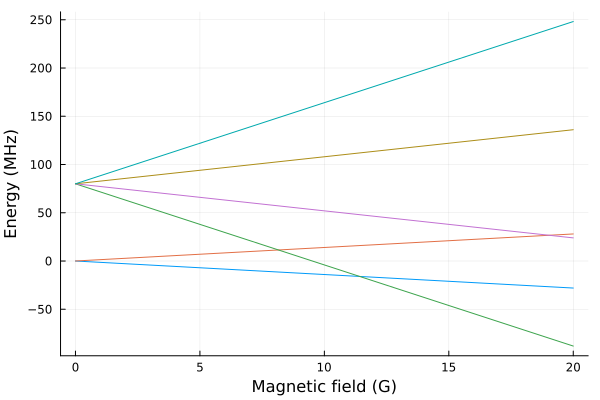

In [13]:
using Plots
plot_values = hcat(values(scan_values)...)'

plot(Bs, plot_values, legend=nothing)
plot!(
    xlabel="Magnetic field (G)",
    ylabel="Energy (MHz)"
)

## Evaluate transition dipole moments and set laser parameters

In [14]:
d = zeros(ComplexF64, 8, 8, 3)
d_ge = zeros(ComplexF64, 6, 2, 3)
basis_tdms = get_tdms_two_bases(ham_g.basis, ham_e.basis, TDM)
tdms_between_states!(d_ge, basis_tdms, ham_g.states, ham_e.states)
d[1:6, 7:8, :] .= d_ge
d[7:8, 1:6,:] .= permutedims(d_ge, (2, 1, 3))
# Think about normalization. Maybe need to normalize by sqrt(2Fu+1)/sqrt(2Fg+1)
;

In [246]:
J12_energy = energy(ham_g.states[1])
J32_energy = energy(ham_g.states[3])
A_energy = energy(ham_e.states[1])

# CaOH MOT settings
I_load = 32 / 2 # mW/cm^2, or 33 mW per beam of 1/e² diameter = 1 cm (divide by 2 to account for power split between SR frequencies)
I_ramped = I_load / 11 # after ramping down the MOT
Isat = π * h * c * (Γ/2π) / (3λ^3)

# Parameters for laser addressing J=1/2
s_J12 = 0.3 #I_load / Isat
δJ12 = 0Γ
pol_J12 = σ⁺
ω_J12 = 2π * (A_energy - J12_energy) + δJ12

# Parameters for laser addressing J=3/2
s_J32 = 0.3 #I_load / Isat
δJ32 = 0Γ
pol_J32 = σ⁺
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

# This function sets the polarization as a function of time; here it's just set to be constant
ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ( rotate_pol(pol_J12, +x̂)); laser1 = Field(+x̂, ϵ1, ω_J12, s_J12)
lasers_J12 = [laser1]

ϵ7  = ϵ( rotate_pol(pol_J32, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_J32, s_J32)
lasers_J32 = [laser7]


s = 30.0
ω = 2π * (A_energy)
ϵ_resonance = ϵ(rotate_pol((σ⁺ + σ⁻) / √2, +ẑ)); resonance_laser1 = Field(+ẑ, ϵ_resonance, ω, s)
ϵ_resonance = ϵ(rotate_pol((σ⁺), +ẑ)); resonance_laser2 = Field(+ẑ, ϵ_resonance, ω, s)

lasers = [resonance_laser1] #, resonance_laser2]
;

In [281]:
# Set initial conditions for the OBE solver
states = [ham_g.states; ham_e.states]
particle = Particle()

# ρ0 = zeros(ComplexF64, length(states), length(states)) 
# for i = 1:6
#     ρ0[i,i] = 1/6
# end

ψ0 = sqrt(0.25) .* sum(vs[:,3:6], dims=2) #[sqrt(1/3), 0, 0, sqrt(2/3), 0, 0.0, 0, 0 * im]
ρ0 = ψ0 * ψ0'

freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

p.v = (0., 0., 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [282]:
t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [283]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, abstol=1e-6)
;

  0.006852 seconds (4.55 k allocations: 4.924 MiB)


In [284]:
sol.t[end], t_end

(628.3185307179587, 628.3185307179587)

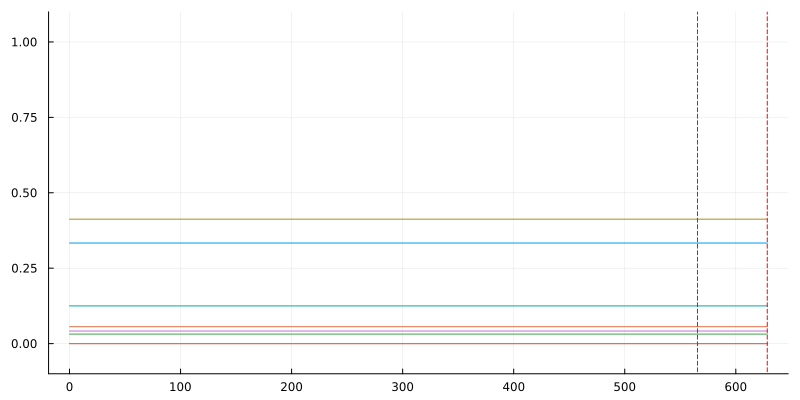

In [285]:
using Plots
plot_us = sol.u
plot_ts = sol.t

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [286]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 3.12985951518563e-6

In [287]:
round.(prob.p.populations, digits=5)

8-element Vector{ComplexF64}:
 0.33333 + 0.0im
 0.05603 + 0.0im
 0.03152 + 0.0im
 0.04167 + 0.0im
 0.41246 + 0.0im
   0.125 + 0.0im
     0.0 + 0.0im
    -0.0 + 0.0im

In [288]:
ρ0 |> diag

8-element Vector{ComplexF64}:
     0.3333333333333333 + 0.0im
    0.05602721371823056 + 0.0im
   0.031515307716504716 + 0.0im
   0.041666666666666644 + 0.0im
    0.41245747856526477 + 0.0im
    0.12500000000000003 + 0.0im
 2.2263750157116446e-31 + 0.0im
                    0.0 + 0.0im

In [198]:
using LinearAlgebra

In [256]:
es, vs = eigen((d[:,:,1] + d[:,:,3]) / √2)
;

In [257]:
es

8-element Vector{Float64}:
 -0.9999999999999988
 -0.9999999999999984
  0.0
  0.0
  0.0
  1.3322676295501878e-15
  0.9999999999999999
  1.0

In [258]:
using PrettyTables

In [259]:
vs[:,3:6] |> pretty_table

┌─────────────────┬─────────────────┬───────────────────┬────────────────────┐
│          Col. 1 │          Col. 2 │            Col. 3 │             Col. 4 │
├─────────────────┼─────────────────┼───────────────────┼────────────────────┤
│       0.0+0.0im │       0.0+0.0im │     0.57735+0.0im │      0.57735+0.0im │
│ -0.289898+0.0im │  0.763299+0.0im │         0.0+0.0im │  3.20494e-16+0.0im │
│  0.644949+0.0im │ -0.289898+0.0im │         0.0+0.0im │  3.92523e-16+0.0im │
│       0.0+0.0im │       0.0+0.0im │    0.816497+0.0im │    -0.408248+0.0im │
│ -0.707107+0.0im │  -0.57735+0.0im │         0.0+0.0im │  2.26623e-16+0.0im │
│       0.0+0.0im │       0.0+0.0im │ 7.85046e-17+0.0im │     0.707107+0.0im │
│       0.0+0.0im │       0.0+0.0im │ 1.11022e-16+0.0im │ -1.05471e-15+0.0im │
│       0.0+0.0im │       0.0+0.0im │         0.0+0.0im │          0.0+0.0im │
└─────────────────┴─────────────────┴───────────────────┴────────────────────┘


## Scan the force and excited state fraction versus velocity

In [78]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= (0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return f_proj
end
;

In [79]:
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 100p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 100

vs = repeat(0:0.5:5, n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


 19.387909 seconds (3.99 M allocations: 276.638 MiB, 35.63% gc time, 43.77% compilation time)


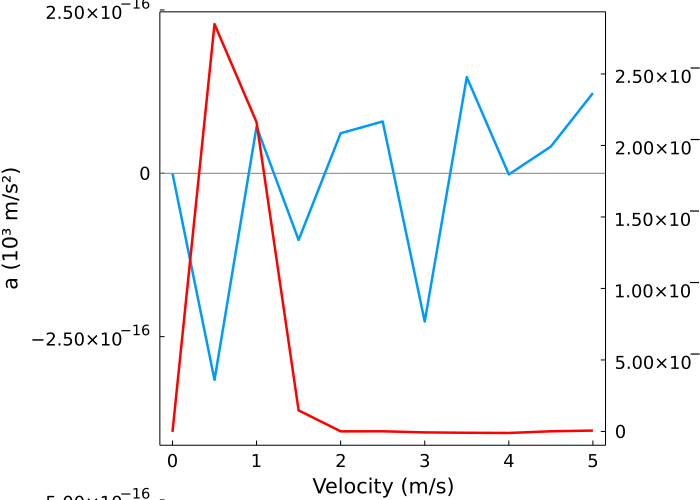

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/ben/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/ben/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191


In [80]:
@time scan_params, forces, populations = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces_velocity = average_values(scan_params, forces)
averaged_forces_velocity[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legend=nothing,
    rightmargin=22Plots.mm,
    grid=:off,
    size=(700,500)
    )
vs, averaged_populations = average_values(scan_params, populations)
plot!(twinx(), vs .* (Γ / k), sum(averaged_populations[:,7:8], dims=2),
    ylabel="Excited state fraction",
    labelfontsize=14,
    xticks=:none,
    linewidth=2.5,
    tickfont=12,
    legend=nothing,
    color=:red
    )
hline!([0], color=:grey)

## Scan the force and excited state fraction versus magnetic field

The force and excited state fraction versus the magnetic field are computed by "re-solving" the $X$ state Hamiltonian, at each magnetic field value, and then updating the transition dipole moments for the new eigenstates. The parameters going into the OBE simulation are updated accordingly.

In order to pass the required data into the OBE simulation, we use the construct `extra_p` (technically, it is defined as a "named tuple"). This variable holds the $X$ state Hamiltonian and transition dipole moments as well as anything else that's needed to update the simulation at each new magnetic field value (specifically, the precomputed transition dipole moments between all different basis states and a vector of the excited states).

In [ ]:
function prob_func!(prob, scan_values, i)
    
    p = prob.p
    extra_p = p.extra_p
    
    Bz = scan_values.Bz[i]
    if extra_p.CaOH_000_N0to3_Hamiltonian.parameters.Bz != Bz
        
        # "Re-solve" Hamiltonian at new magnetic field
        extra_p.CaOH_000_N0to3_Hamiltonian.parameters.Bz = Bz
        evaluate!(extra_p.CaOH_000_N0to3_Hamiltonian)
        QuantumStates.solve!(extra_p.CaOH_000_N0to3_Hamiltonian)
         for i ∈ eachindex(extra_p.CaOH_000_N0to3_Hamiltonian.states)
            extra_p.CaOH_000_N0to3_Hamiltonian.states[i].E *= 1e6
        end
        states = extra_p.CaOH_000_N0to3_Hamiltonian.states[5:16]
        
        # Update transition dipole moments
        tdms_between_states!(extra_p.d_ge, extra_p.basis_tdms, states, extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= extra_p.d_ge
        
        states′ = [states; extra_p.states_A_J12_caseB]

        # Update the "extra" parameters that go into the OBEs
        extra_p = (
            basis_tdms=extra_p.basis_tdms, 
            CaOH_000_N0to3_Hamiltonian=extra_p.CaOH_000_N0to3_Hamiltonian, 
            d_ge=extra_p.d_ge,
            states_A_J12_caseB=extra_p.states_A_J12_caseB)
        
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= sample_direction(0.0)
    new_p.fields.ω .= p.fields.ω
    new_p.r0 .= rand(uniform_dist, 3)
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return f_proj
end
;

In [ ]:
freq_res = 1e-1
extra_p = (
    basis_tdms=basis_tdms,
    CaOH_000_N0to3_Hamiltonian=CaOH_000_N0to3_Hamiltonian, 
    d_ge=d_ge,
    states_A_J12_caseB=states_A_J12_caseB
)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 100p.period; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 100

Bzs = repeat(0:2.:50, n_samples)
scan_values = (Bz = Bzs,)
;

In [ ]:
@time scan_params, forces, populations = force_scan(prob, scan_values, prob_func!, param_func, output_func);
Bzs, averaged_forces_velocity = average_values(scan_params, forces)
averaged_forces_velocity[1] = 0.0
plot(Bzs, (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legend=nothing,
    rightmargin=22Plots.mm,
    grid=:off,
    size=(700,500)
    )
vs, averaged_populations = average_values(scan_params, populations)
plot!(twinx(), Bzs, sum(averaged_populations[:,13:16], dims=2),
    ylabel="Excited state fraction",
    labelfontsize=14,
    xticks=:none,
    linewidth=2.5,
    tickfont=12,
    legend=nothing,
    color=:red
    )
hline!([0], color=:grey)